# Asset Predictive Maintenance use-case for a Synthetic Railway Company
 
 * Check Readme file for project insight
 * All code and approach made by me, main references and sources are specified. 
 
<a id='bookmark_index'></a>
# Index <small> [click to navigate] </small>
 1. <a href=#bookmark_intro>Introduction</a>
 1. <a href=#bookmark_familiar>Getting faimiliar with the data</a>
 2. <a href=#bookmark_features>Building feature datasets</a>
 2. My Approach
 3. <a href=#bookmark_process>Data processing</a>
 4. <a href=#bookmark_model>Models training</a>
 5. <a href=#bookmark_res>Results & Conclusions</a>
 
<a id='bookmark_intro'></a>
# Introduction

What is predictive maintenance: In predictive maintenance scenarios, data is collected over time to monitor the state of equipment. The goal is to find patterns that can help predict and ultimately prevent failures.

The goal of this project is to answer two main questions:¶
* When will an event occur for the given asset?
* What are the main causes of problems?

In [1]:
# importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# dataset files location
folder_path = './SyntheticData/'

In [3]:
# get all files
files = os.listdir(folder_path)
print(files)

# organize all files in a dictionary of dataframes
df_dict = {}
filenames = []
for file in files: 
    filenames.append(file[:-4])  # slice .csv extension from name
    df_dict[file[:-4]] = pd.read_csv(folder_path + file)    

['asset_attribute_data_general.csv', 'asset_attribute_data_usage.csv', 'asset_attribute_data_weather.csv', 'asset_data.csv', 'planned_data.csv', 'repair_data.csv', 'replacement_data.csv']


<a id='bookmark_familiar'></a>
# 2. Getting familiar with the data <small> [<a href=#bookmark_index>Go to index</a>] </small>

In [4]:
df_dict['asset_attribute_data_general'].head()

,asset_id,asset_install_team,asset_line,asset_material
0,A:cpjwvv,team4,east_line,iron
1,A:xoauw0,team3,south_line,steel
2,A:xpqps2,team1,east_line,iron
3,A:m44bmt,team4,west_line,steel
4,A:rwkyh1,team2,north_line,steel


In [5]:
df_dict['asset_attribute_data_usage'].head()

,asset_id,asset_trains_per_hour
0,A:cpjwvv,2.0
1,A:xoauw0,4.0
2,A:xpqps2,4.0
3,A:m44bmt,4.0
4,A:rwkyh1,1.0


In [6]:
df_dict['asset_attribute_data_weather'].head()

,asset_id,asset_weather_cluster
0,A:cpjwvv,standard
1,A:xoauw0,standard
2,A:xpqps2,sun
3,A:m44bmt,sun
4,A:rwkyh1,standard


In [7]:
df_dict['asset_data'].head()

,asset_id,end_date,latitude,longitude,previous_repairs,previous_unplanned,start_date
0,A:cpjwvv,2012-02-26,51.108966,-1.382032,0,0,2008-06-26
1,A:xoauw0,2005-03-01,58.369692,-4.982743,0,0,2003-06-08
2,A:xpqps2,2009-10-27,55.759249,-4.593591,0,0,2007-03-03
3,A:m44bmt,2008-02-23,52.289685,-1.418834,0,0,2007-01-17
4,A:rwkyh1,2013-06-21,55.686979,-4.542553,0,0,2012-06-03


The previous/above tables all share an identification column that could be used to merge them: <b> asset_id </b>

In [8]:
df_dict['planned_data'].head()

,asset_id,event_date,event_id,planned
0,A:cpjwvv,2011-05-06,E:6avbyn53sz,False
1,A:cpjwvv,2008-08-30,E:trj6ixh0o9,False
2,A:cpjwvv,2009-02-06,E:y5bjtvl55l,False
3,A:cpjwvv,2010-02-07,E:evsbi3vj21,False
4,A:cpjwvv,2010-02-17,E:njcddphr3b,False


In [9]:
df_dict['repair_data'].head()

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned
0,A:cpjwvv,2011-05-06,E:6avbyn53sz,2011-03-25,1,1
1,A:xoauw0,2004-05-10,E:8h4dpsljy3,2003-08-28,1,1
2,A:xoauw0,2004-10-18,E:zl0sp2rps7,2004-05-10,2,2
3,A:xpqps2,2009-09-07,E:ndxhmxamfi,2007-10-03,1,1
4,A:m44bmt,2007-03-29,E:01zkvga68v,2007-03-26,1,1


In [10]:
df_dict['replacement_data'].head()

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned
0,A:cpjwvv,2008-08-30,E:trj6ixh0o9,2008-06-26,0,0
1,A:cpjwvv,2009-02-06,E:y5bjtvl55l,2008-08-30,0,0
2,A:cpjwvv,2010-02-07,E:evsbi3vj21,2009-02-06,0,0
3,A:cpjwvv,2010-02-17,E:njcddphr3b,2010-02-07,0,0
4,A:cpjwvv,2010-05-18,E:fry99yixfk,2010-02-17,0,0


The previous/above tables all share columns <b> asset_id </b> and <b> event_id </b> that are going be used to merge them

In [11]:
# Check datasets size
for name in filenames:
    print(name, df_dict[name].shape)

asset_attribute_data_general (200, 4)
asset_attribute_data_usage (200, 2)
asset_attribute_data_weather (200, 2)
asset_data (200, 7)
planned_data (2032, 4)
repair_data (859, 6)
replacement_data (1173, 6)


* More repairs than replacements, means unbalanced data regarding type of event
* In order to distinguish repairs from replacements, might be useful to create a feature that could differenciate these events
* 200 assets, 2032 events, distributed by repairs and replacements (859+1173=2032)

<a id='bookmark_features'></a>
# 3. Building feature datasets <small>[<a href=#bookmark_index>Go to index</a>]</small>
Merging and droping

#### Assets feature dataset - Merging assets data according to asset_id

In [12]:
df_assets_or = pd.merge(df_dict['asset_attribute_data_general'], df_dict['asset_attribute_data_usage'], on='asset_id')
df_assets_or = pd.merge(df_assets_or, df_dict['asset_attribute_data_weather'], on='asset_id')

In [13]:
df_assets_or

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster
0,A:cpjwvv,team4,east_line,iron,2.0,standard
1,A:xoauw0,team3,south_line,steel,4.0,standard
2,A:xpqps2,team1,east_line,iron,4.0,sun
3,A:m44bmt,team4,west_line,steel,4.0,sun
4,A:rwkyh1,team2,north_line,steel,1.0,standard
...,...,...,...,...,...,...
195,A:271d3q,team4,south_line,iron,4.0,standard
196,A:6tjk91,team3,west_line,iron,4.0,standard
197,A:j9z5oa,team2,east_line,iron,8.0,heavy_rain
198,A:100egl,team2,west_line,alloy,2.0,sun


In [14]:
df_assets_or = pd.merge(df_assets_or, df_dict['asset_data'], on='asset_id')

In [15]:
df_assets_or

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,end_date,latitude,longitude,previous_repairs,previous_unplanned,start_date
0,A:cpjwvv,team4,east_line,iron,2.0,standard,2012-02-26,51.108966,-1.382032,0,0,2008-06-26
1,A:xoauw0,team3,south_line,steel,4.0,standard,2005-03-01,58.369692,-4.982743,0,0,2003-06-08
2,A:xpqps2,team1,east_line,iron,4.0,sun,2009-10-27,55.759249,-4.593591,0,0,2007-03-03
3,A:m44bmt,team4,west_line,steel,4.0,sun,2008-02-23,52.289685,-1.418834,0,0,2007-01-17
4,A:rwkyh1,team2,north_line,steel,1.0,standard,2013-06-21,55.686979,-4.542553,0,0,2012-06-03
...,...,...,...,...,...,...,...,...,...,...,...,...
195,A:271d3q,team4,south_line,iron,4.0,standard,2012-05-12,52.883360,-2.048643,0,0,2005-10-15
196,A:6tjk91,team3,west_line,iron,4.0,standard,2016-07-08,54.765397,-2.104487,0,0,2013-08-22
197,A:j9z5oa,team2,east_line,iron,8.0,heavy_rain,2017-06-01,54.332715,-2.370033,0,0,2013-05-21
198,A:100egl,team2,west_line,alloy,2.0,sun,2013-08-18,54.151059,-2.068212,0,0,2008-05-04


In [16]:
# keep original dataframe df_assets_or unchanged, might be useful in the future
df_assets = df_assets_or
# Remove latitude and longitude features. Realy hard to work with coordinates.
df_assets = df_assets.drop(['latitude', 'longitude'], axis=1)

In [17]:
# Dont quite understand whats the logic behind these two features in these exact table.
# In a professional scenario this features would need to be discussed to get more insight and assess their importance 
# to the business and goal of the project, but for the purpose of this assignment im going to drop them
df_assets = df_assets.drop(['previous_repairs', 'previous_unplanned'], axis=1)

In [18]:
# Just organizing the columns to help me vizualize
def move_col(name, pos):
    column = df_assets.pop(name)
    df_assets.insert(pos, name, column)
    
move_col('start_date', 1)
move_col('end_date', 2)
df_assets

,asset_id,start_date,end_date,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster
0,A:cpjwvv,2008-06-26,2012-02-26,team4,east_line,iron,2.0,standard
1,A:xoauw0,2003-06-08,2005-03-01,team3,south_line,steel,4.0,standard
2,A:xpqps2,2007-03-03,2009-10-27,team1,east_line,iron,4.0,sun
3,A:m44bmt,2007-01-17,2008-02-23,team4,west_line,steel,4.0,sun
4,A:rwkyh1,2012-06-03,2013-06-21,team2,north_line,steel,1.0,standard
...,...,...,...,...,...,...,...,...
195,A:271d3q,2005-10-15,2012-05-12,team4,south_line,iron,4.0,standard
196,A:6tjk91,2013-08-22,2016-07-08,team3,west_line,iron,4.0,standard
197,A:j9z5oa,2013-05-21,2017-06-01,team2,east_line,iron,8.0,heavy_rain
198,A:100egl,2008-05-04,2013-08-18,team2,west_line,alloy,2.0,sun


Going to create new feature: <b> life_time </b>, represents days between the start and end dates of the asset

In [19]:
# convert dates to datetime
df_assets['start_date'] = pd.to_datetime(df_assets['start_date'], format='%Y-%m-%d', errors='ignore')
df_assets['end_date'] = pd.to_datetime(df_assets['end_date'], format='%Y-%m-%d', errors='ignore')

# new life time variable with the total working days of the asset
df_assets['life_time'] = (df_assets['end_date'] - df_assets['start_date']).dt.days

# drop uncessary columns
df_assets = df_assets.drop(['start_date', 'end_date'], axis=1)

In [20]:
df_assets

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,life_time
0,A:cpjwvv,team4,east_line,iron,2.0,standard,1340
1,A:xoauw0,team3,south_line,steel,4.0,standard,632
2,A:xpqps2,team1,east_line,iron,4.0,sun,969
3,A:m44bmt,team4,west_line,steel,4.0,sun,402
4,A:rwkyh1,team2,north_line,steel,1.0,standard,383
...,...,...,...,...,...,...,...
195,A:271d3q,team4,south_line,iron,4.0,standard,2401
196,A:6tjk91,team3,west_line,iron,4.0,standard,1051
197,A:j9z5oa,team2,east_line,iron,8.0,heavy_rain,1472
198,A:100egl,team2,west_line,alloy,2.0,sun,1932


#### Repairs/Replacements feature dataset - Merging events data according to events_id and assets_id

Creating new boolean feature: <b> type_of_event </b>. If 1 is a repair, else is a replacement

In [21]:
# repairs = 1
df_dict['repair_data']['type_of_event'] = 1
# replacements = 0
df_dict['replacement_data']['type_of_event'] = 0

In [22]:
df_repairs_or = pd.merge(
    df_dict['repair_data'], 
    df_dict['replacement_data'], 
    on=['asset_id', 'event_id', 'event_date', 'installed_date', 'previous_repairs', 'previous_unplanned', 'type_of_event'], 
    how='outer')

In [23]:
df_repairs_or

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned,type_of_event
0,A:cpjwvv,2011-05-06,E:6avbyn53sz,2011-03-25,1,1,1
1,A:xoauw0,2004-05-10,E:8h4dpsljy3,2003-08-28,1,1,1
2,A:xoauw0,2004-10-18,E:zl0sp2rps7,2004-05-10,2,2,1
3,A:xpqps2,2009-09-07,E:ndxhmxamfi,2007-10-03,1,1,1
4,A:m44bmt,2007-03-29,E:01zkvga68v,2007-03-26,1,1,1
...,...,...,...,...,...,...,...
2027,A:bo36ea,2008-03-11,E:tiimfa24q1,2007-12-13,0,0,0
2028,A:bo36ea,2008-06-08,E:o7x8b82wrs,2008-05-26,0,0,0
2029,A:bo36ea,2008-06-08,E:urquo998rq,2008-06-08,0,0,0
2030,A:bo36ea,2008-12-12,E:cxh6sozhrx,2008-06-08,0,0,0


In [24]:
df_repairs_or = pd.merge(
    df_repairs_or, 
    df_dict['planned_data'], 
    on=['asset_id', 'event_id', 'event_date'])

In [25]:
df_repairs_or

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned,type_of_event,planned
0,A:cpjwvv,2011-05-06,E:6avbyn53sz,2011-03-25,1,1,1,False
1,A:xoauw0,2004-05-10,E:8h4dpsljy3,2003-08-28,1,1,1,False
2,A:xoauw0,2004-10-18,E:zl0sp2rps7,2004-05-10,2,2,1,False
3,A:xpqps2,2009-09-07,E:ndxhmxamfi,2007-10-03,1,1,1,False
4,A:m44bmt,2007-03-29,E:01zkvga68v,2007-03-26,1,1,1,False
...,...,...,...,...,...,...,...,...
2027,A:bo36ea,2008-03-11,E:tiimfa24q1,2007-12-13,0,0,0,False
2028,A:bo36ea,2008-06-08,E:o7x8b82wrs,2008-05-26,0,0,0,False
2029,A:bo36ea,2008-06-08,E:urquo998rq,2008-06-08,0,0,0,True
2030,A:bo36ea,2008-12-12,E:cxh6sozhrx,2008-06-08,0,0,0,False


In [26]:
# keep original dataframe df_repairs_or unchanged
df_repairs = df_repairs_or
# set date vars to datetime type
df_repairs['event_date'] = pd.to_datetime(df_repairs['event_date'], format='%Y-%m-%d', errors='ignore')
df_repairs['installed_date'] = pd.to_datetime(df_repairs['installed_date'], format='%Y-%m-%d', errors='ignore')

Going to create new feature: <b> RUL </b> (Remaining useful life), represents days between next asset event and in our dataset its the difference between installed_date and event_date

In [27]:
df_repairs['RUL'] = (df_repairs['event_date'] - df_repairs['installed_date']).dt.days
# remove features that are not going to be used
df_repairs = df_repairs.drop(['event_id'], axis=1)
# order by dates
df_repairs = df_repairs.sort_values(by='installed_date')

In [28]:
df_repairs

,asset_id,event_date,installed_date,previous_repairs,previous_unplanned,type_of_event,planned,RUL
327,A:hhuqjc,2000-03-02,2000-01-06,1,0,1,True,56
496,A:g387mk,2000-05-07,2000-01-27,1,1,1,False,101
1018,A:u65cz7,2000-02-26,2000-02-15,0,0,0,False,11
725,A:5j07tf,2001-10-07,2000-02-17,1,1,1,False,598
1019,A:u65cz7,2000-08-11,2000-02-26,0,0,0,False,167
...,...,...,...,...,...,...,...,...
1473,A:ii3vcg,2017-05-01,2017-02-27,0,0,0,False,63
1931,A:tzbon5,2017-05-11,2017-03-04,0,0,0,False,68
1972,A:4f0kgt,2017-04-02,2017-03-27,0,0,0,False,6
666,A:9ks73c,2017-05-02,2017-04-05,1,1,1,False,27


#### Comparing and analysing assets info with repairements/replacements

Trying to understand the data logic. Analyse asset 'A:cpjwvv' events

In [29]:
df_repairs.loc[df_repairs['asset_id'] == 'A:cpjwvv', :]

,asset_id,event_date,installed_date,previous_repairs,previous_unplanned,type_of_event,planned,RUL
859,A:cpjwvv,2008-08-30,2008-06-26,0,0,0,False,65
860,A:cpjwvv,2009-02-06,2008-08-30,0,0,0,False,160
861,A:cpjwvv,2010-02-07,2009-02-06,0,0,0,False,366
862,A:cpjwvv,2010-02-17,2010-02-07,0,0,0,False,10
863,A:cpjwvv,2010-05-18,2010-02-17,0,0,0,False,90
864,A:cpjwvv,2010-06-03,2010-05-18,0,0,0,False,16
865,A:cpjwvv,2010-08-06,2010-06-03,0,0,0,False,64
866,A:cpjwvv,2010-09-01,2010-08-06,0,0,0,False,26
867,A:cpjwvv,2010-12-19,2010-09-01,0,0,0,False,109
868,A:cpjwvv,2011-03-25,2010-12-19,0,0,0,False,96


In [30]:
df_assets.loc[df_assets['asset_id'] == 'A:cpjwvv', :]

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,life_time
0,A:cpjwvv,team4,east_line,iron,2.0,standard,1340


Cheking another randomly chosen asset to understand the data logic 'A:m44bmt'

In [31]:
df_repairs.loc[df_repairs['asset_id'] == 'A:m44bmt', :]

,asset_id,event_date,installed_date,previous_repairs,previous_unplanned,type_of_event,planned,RUL
877,A:m44bmt,2007-03-26,2007-01-17,0,0,0,False,68
4,A:m44bmt,2007-03-29,2007-03-26,1,1,1,False,3
878,A:m44bmt,2007-10-08,2007-03-29,0,0,0,False,193
879,A:m44bmt,2007-11-07,2007-10-08,0,0,0,False,30
5,A:m44bmt,2008-01-22,2007-11-07,1,1,1,False,76


In [32]:
df_assets.loc[df_assets['asset_id'] == 'A:m44bmt', :]

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,life_time
3,A:m44bmt,team4,west_line,steel,4.0,sun,402


* Start date in asset_data corresponds to the earlier date of the installed date;
* When there is an event, the date will count as the installed date for next event
* What is the end date used for?

#### Main feature dataset - Combined feature dataset with asset and repairs data

In [33]:
df_main_or = pd.merge(
    df_repairs, 
    df_assets, 
    on=['asset_id'])

In [34]:
df_main_or

,asset_id,event_date,installed_date,previous_repairs,previous_unplanned,type_of_event,planned,RUL,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,life_time
0,A:hhuqjc,2000-03-02,2000-01-06,1,0,1,True,56,team4,west_line,iron,4.0,standard,2962
1,A:hhuqjc,2000-11-20,2000-03-02,0,0,0,False,263,team4,west_line,iron,4.0,standard,2962
2,A:hhuqjc,2001-04-09,2000-11-20,0,0,0,False,140,team4,west_line,iron,4.0,standard,2962
3,A:hhuqjc,2001-09-02,2001-04-09,0,0,0,False,146,team4,west_line,iron,4.0,standard,2962
4,A:hhuqjc,2001-10-28,2001-09-02,0,0,0,True,56,team4,west_line,iron,4.0,standard,2962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,A:1xy43l,2016-12-02,2016-10-07,1,0,1,True,56,team3,west_line,iron,4.0,rain,237
2028,A:tzbon5,2017-02-06,2016-11-12,1,3,1,False,86,team3,north_line,alloy,16.0,standard,201
2029,A:tzbon5,2017-03-04,2017-02-06,0,0,0,False,26,team3,north_line,alloy,16.0,standard,201
2030,A:tzbon5,2017-05-11,2017-03-04,0,0,0,False,68,team3,north_line,alloy,16.0,standard,201


In [35]:
# how many events per asset
df_main_or['asset_id'].value_counts()

A:klvrkr    40
A:4dos97    38
A:atorvu    36
A:u8uma6    33
A:6tveej    30
            ..
A:w9zka1     1
A:x38ptc     1
A:q0n833     1
A:1mu3do     1
A:o56vf4     1
Name: asset_id, Length: 194, dtype: int64

In [36]:
# Check for null values
df_main_or.isnull().sum()

asset_id                 0
event_date               0
installed_date           0
previous_repairs         0
previous_unplanned       0
type_of_event            0
planned                  0
RUL                      0
asset_install_team       0
asset_line               0
asset_material           0
asset_trains_per_hour    0
asset_weather_cluster    0
life_time                0
dtype: int64

<a id='bookmark_process'></a>
# 4. Data processing <small> [<a href=#bookmark_index>Go to index</a>] </small>
Feature dataset cleaning and shaping - pre prepation for training phase

In [37]:
# keep original dataframe untouched
df_main = df_main_or
# remove unecessary features
df_main = df_main.drop(['asset_id', 'event_date', 'installed_date'], axis=1)

In [38]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical data into numerical
label_encoder = LabelEncoder()

df_main['asset_install_team'] = label_encoder.fit_transform(df_main['asset_install_team'])
df_main['planned'] = label_encoder.fit_transform(df_main['planned'])
df_main['asset_line'] = label_encoder.fit_transform(df_main['asset_line'])
df_main['asset_material'] = label_encoder.fit_transform(df_main['asset_material'])
df_main['asset_weather_cluster'] = label_encoder.fit_transform(df_main['asset_weather_cluster'])
df_main.head(2)

,previous_repairs,previous_unplanned,type_of_event,planned,RUL,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,life_time
0,1,0,1,1,56,3,3,1,4.0,3,2962
1,0,0,0,0,263,3,3,1,4.0,3,2962


In [39]:
df_main.describe()

,previous_repairs,previous_unplanned,type_of_event,planned,RUL,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,life_time
count,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000
mean,0.689469,0.585138,0.422736,0.142224,135.772638,1.582185,1.589075,1.049705,9.251476,2.435039,2155.086122
std,1.014191,1.039655,0.494116,0.349366,148.570273,1.094338,1.139220,0.781992,9.237671,1.081018,906.363022
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,104.000000
25%,0.000000,0.000000,0.000000,0.000000,37.000000,1.000000,1.000000,0.000000,4.000000,2.000000,1385.000000
50%,0.000000,0.000000,0.000000,0.000000,90.000000,1.000000,2.000000,1.000000,4.000000,3.000000,2279.000000
75%,1.000000,1.000000,1.000000,0.000000,181.250000,3.000000,3.000000,2.000000,16.000000,3.000000,3025.000000
max,6.000000,11.000000,1.000000,1.000000,1385.000000,3.000000,3.000000,2.000000,32.000000,4.000000,3579.000000


In [40]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2032 entries, 0 to 2031
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   previous_repairs       2032 non-null   int64  
 1   previous_unplanned     2032 non-null   int64  
 2   type_of_event          2032 non-null   int64  
 3   planned                2032 non-null   int64  
 4   RUL                    2032 non-null   int64  
 5   asset_install_team     2032 non-null   int32  
 6   asset_line             2032 non-null   int32  
 7   asset_material         2032 non-null   int32  
 8   asset_trains_per_hour  2032 non-null   float64
 9   asset_weather_cluster  2032 non-null   int32  
 10  life_time              2032 non-null   int64  
dtypes: float64(1), int32(4), int64(6)
memory usage: 158.8 KB


In [41]:
# set type of feature, this way all features become of the same type since they are all integers
df_main['asset_trains_per_hour'] = df_main['asset_trains_per_hour'].astype('Int64')
print(df_main['asset_trains_per_hour'].dtypes)

Int64


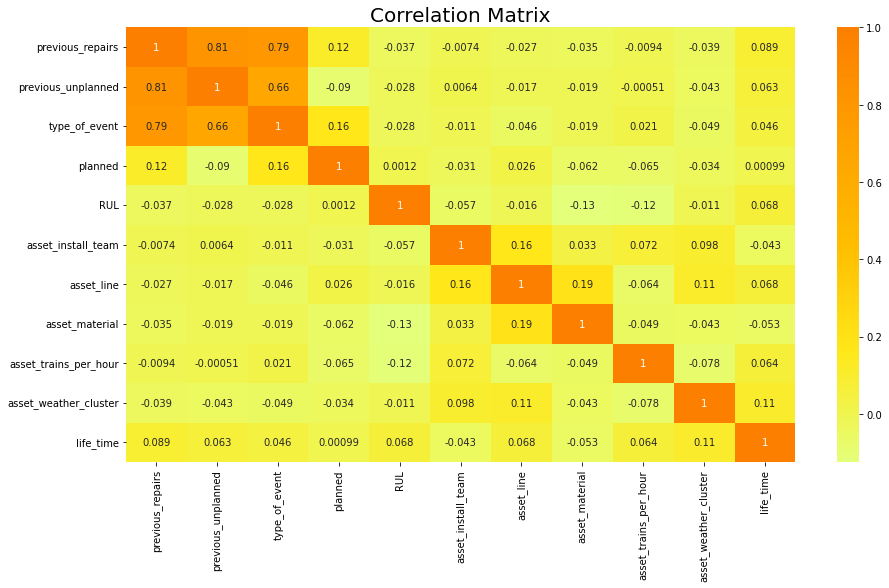

In [42]:
# check features correlation
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(df_main.corr(), cmap = 'Wistia', annot = True)
plt.title('Correlation Matrix', fontsize = 20)
plt.show()

Considerable correlation between previous_repairs, previous_unplannd, planned and event_type

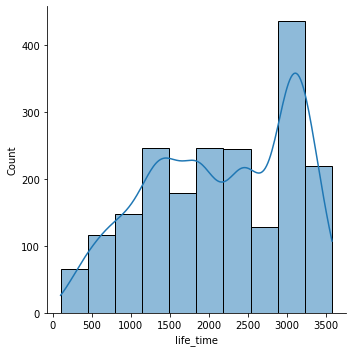

In [43]:
sns.displot(df_main['life_time'], bins=10, kde=True)

c:\users\manuelsousa\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='life_time'>

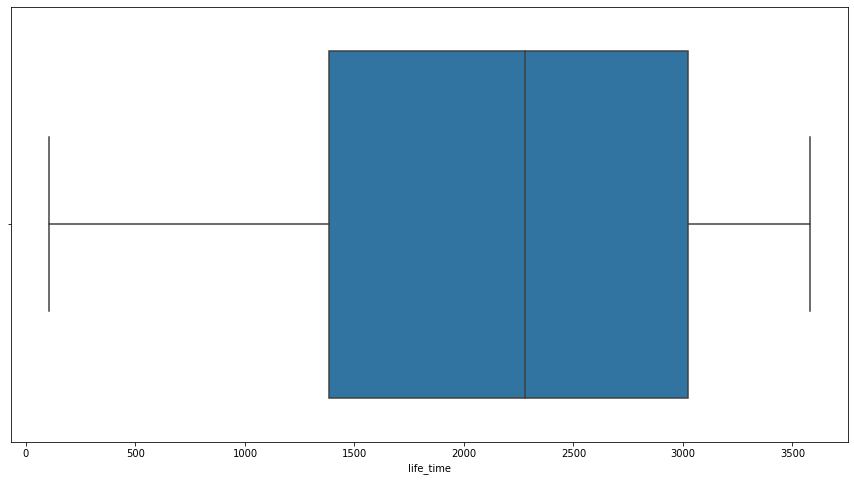

In [44]:
sns.boxplot(df_main['life_time'])

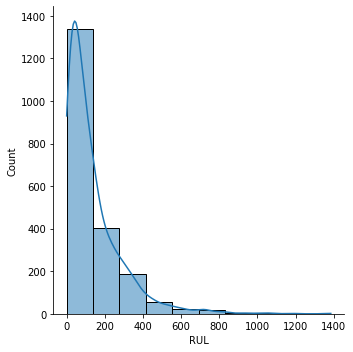

In [45]:
sns.displot(df_main['RUL'], bins=10, kde=True)

c:\users\manuelsousa\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='RUL'>

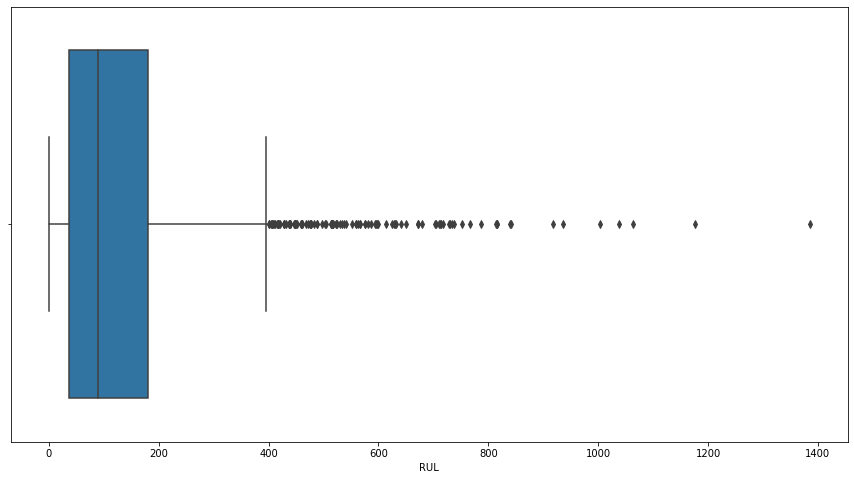

In [46]:
sns.boxplot(df_main['RUL'])

About target continues variable RUL:
* No normal distribution (bell curve)
* Boxplot show a lot os outliers

In [47]:
# target vector - Remaining useful life
y = df_main['RUL']

# feature matrix
X = df_main.loc[:, df_main.columns != 'RUL']

The training/testing split be 80/20

In [48]:
from sklearn.model_selection import train_test_split

# 80/20 training and testing splitting - Pareto principle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [49]:
# Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

In [50]:
# [4] pag.145 & [5]
# https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/
# https://www.machinelearningplus.com/machine-learning/principal-components-analysis-pca-better-explained/
# https://stackoverflow.com/questions/32857029/python-scikit-learn-pca-explained-variance-ratio-cutoff
# https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn

from sklearn.decomposition import PCA
 
pca = PCA()  # n_components=8
pca.fit(X_scaled)
# transform data accordinh to the chosen components
X_pca_train = pca.transform(X_scaled)
X_pca_test = pca.transform(X_test)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca_train.shape)))

Original shape: (1625, 10)
Reduced shape: (1625, 10)


c:\users\manuelsousa\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [51]:
# Percentage on each PCi component chosen
pca.explained_variance_ratio_

array([0.25710856, 0.13227342, 0.11384723, 0.11188905, 0.1008625 ,
       0.09904186, 0.07598359, 0.07023426, 0.02695462, 0.01180491])

In [52]:
pca.components_.T

array([[ 5.96238367e-01, -3.85713849e-02,  1.93055612e-02,
         2.89742577e-03, -3.26632614e-03,  2.74461763e-02,
         5.06811895e-03,  7.18395527e-04,  2.15438521e-01,
        -7.71639190e-01],
       [ 5.59191552e-01, -4.48704020e-02, -9.55430032e-02,
        -1.55581214e-01, -1.78234582e-01,  7.07631379e-02,
        -5.23890066e-02,  7.77252028e-02,  5.20102198e-01,
         5.79560503e-01],
       [ 5.60268282e-01, -1.16260895e-02,  6.39659539e-02,
         1.66141916e-02,  9.37138009e-02,  9.03633262e-03,
         9.60419580e-02, -1.48842971e-02, -7.85121785e-01,
         2.16496797e-01],
       [ 8.58595888e-02,  1.33004870e-02,  4.61476056e-01,
         5.47937290e-01,  5.69035229e-01, -8.77229972e-02,
         2.20293787e-01, -1.33648501e-01,  2.46324945e-01,
         1.43847610e-01],
       [-1.16399978e-02, -4.26276896e-01, -3.20674117e-01,
        -1.66951686e-01,  5.15233144e-01,  3.76188396e-01,
        -3.30046420e-01, -4.13899659e-01,  5.46414062e-03,
         1.

In [53]:
n_pcs= pca.components_.shape[0]
most_relevant_features = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
print(most_relevant_features)

[0, 5, 7, 3, 3, 9, 8, 5, 2, 0]


In [54]:
df_main.columns[most_relevant_features]

Index(['previous_repairs', 'asset_install_team', 'asset_material', 'planned',
       'planned', 'asset_weather_cluster', 'asset_trains_per_hour',
       'asset_install_team', 'type_of_event', 'previous_repairs'],
      dtype='object')

In [55]:
result = [] 
for i in most_relevant_features: 
    if i not in result: 
        result.append(i) 
print(result)

[0, 5, 7, 3, 9, 8, 2]


In [56]:
# According to PCA algorithm the most relevant features are the following
print("PCA - Most relevant features:")
i = 1
for column in df_main.columns[result]:        
    print(i, column)
    i += 1

PCA - Most relevant features:
1 previous_repairs
2 asset_install_team
3 asset_material
4 planned
5 asset_weather_cluster
6 asset_trains_per_hour
7 type_of_event


#### The following metrics are going to be used to evaluate the models performance: MAE, MSE and RMSE

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(real, pred):
    mae = mean_absolute_error(real, pred)
    mse = mean_squared_error(real, pred)
    rmse = mean_squared_error(real, pred, squared=False)
    return {'mae': mae, 'mse': mse, 'rmse': rmse}

<a id='bookmark_model'></a>
# 5. Models training <small> [<a href=#bookmark_index>Go to index</a>] </small>

#### Decision Tree

In [58]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

param = {'splitter':('best', 'random'), 
         'max_depth' : [1,2,3,4,5,10], 
         'min_samples_leaf' : [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35]}

dtr_model = RandomizedSearchCV(DecisionTreeRegressor(), param)
dtr_model.fit(X_pca_train, y_train)

RandomizedSearchCV(estimator=DecisionTreeRegressor(),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 10],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 10,
                                                             15, 20, 25, 30,
                                                             35],
                                        'splitter': ('best', 'random')})

In [59]:
dtr_model.best_estimator_

DecisionTreeRegressor(max_depth=4, min_samples_leaf=20, splitter='random')

In [60]:
dtr_pred_train = dtr_model.predict(X_pca_train)
dtr_train_score = evaluate(y_train, dtr_pred_train)
print(dtr_train_score)

{'mae': 104.91006353321796, 'mse': 22069.65663401807, 'rmse': 148.55859663452017}


In [61]:
dtr_pred_test = dtr_model.predict(X_pca_test)
dtr_test_score = evaluate(y_test, dtr_pred_test)
print(dtr_test_score)

{'mae': 92.8434630803052, 'mse': 18124.441442008618, 'rmse': 134.62704573007838}


In [62]:
dtr_res = pd.DataFrame({
    'Model': ['Decision tree'], 
    'Test MAE': dtr_test_score['mae'], 
    'Test MSE': dtr_test_score['mse'] , 
    'Test RMSE': dtr_test_score['rmse'] 
})

#### Random Forest

In [63]:
from sklearn.ensemble import RandomForestRegressor

param = {'max_depth' : [1,2,3,4,5,10], 
         'min_samples_leaf' : [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 42, 44, 46, 48, 50, 52]}

rfr_model = RandomizedSearchCV(RandomForestRegressor(verbose=1, n_jobs=-1), param)
rfr_model.fit(X_pca_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]:

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using

RandomizedSearchCV(estimator=RandomForestRegressor(n_jobs=-1, verbose=1),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 10],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 10,
                                                             15, 20, 25, 30, 35,
                                                             40, 42, 44, 46, 48,
                                                             50, 52]})

In [64]:
rfr_model.best_estimator_

RandomForestRegressor(max_depth=4, min_samples_leaf=52, n_jobs=-1, verbose=1)

In [65]:
rfr_pred_train = rfr_model.predict(X_pca_train)
rfr_train_score = evaluate(y_train, rfr_pred_train)
print(rfr_train_score)

{'mae': 102.65010350703777, 'mse': 21125.557368996986, 'rmse': 145.34633593247884}


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [66]:
rfr_pred_test = rfr_model.predict(X_pca_test)
rfr_test_score = evaluate(y_test, rfr_pred_test)
print(rfr_test_score)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


{'mae': 128.3702739503627, 'mse': 22346.316219331904, 'rmse': 149.4868429639609}


In [67]:
rfr_res = pd.DataFrame({
    'Model': ['Random Forest'],
    'Test MAE': rfr_test_score['mae'], 
    'Test MSE': rfr_test_score['mse'], 
    'Test RMSE': rfr_test_score['rmse'] 
})

r1 = dtr_res.append(rfr_res, ignore_index=True)

#### Gradient Boosting

In [68]:
from xgboost import XGBRegressor

param = {'max_depth' : [1,2,3,4,5,10], 
         'n_estimators' : [5, 10, 15, 20, 25, 30, 50, 100, 200, 500, 700, 1000]}

xgbr_model = RandomizedSearchCV(XGBRegressor(eta=0.01), param)

# This dataset is going to be used for early_stopping, preventing the model from overfitting
eval_set = [(X_pca_test, y_test)]

# Build model 
xgbr_model.fit(X_pca_train, y_train, early_stopping_rounds=10, eval_set=eval_set, verbose=False)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, eta=0.01,
                                          gamma=None, gpu_id=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                       

In [69]:
xgbr_model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.01, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.00999999978,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [70]:
xgbr_pred_train = xgbr_model.predict(X_pca_train)
xgbr_train_score = evaluate(y_train, xgbr_pred_train)
print(xgbr_train_score)

{'mae': 94.17568795306866, 'mse': 21597.11823824709, 'rmse': 146.9595802873943}


In [71]:
xgbr_pred_test = xgbr_model.predict(X_pca_test)
xgbr_test_score = evaluate(y_test, xgbr_pred_test)
print(xgbr_test_score)

{'mae': 98.0718425029033, 'mse': 17705.838142337994, 'rmse': 133.06328623004165}


In [72]:
xgbr_model.best_estimator_.feature_importances_

array([0.06255089, 0.0917539 , 0.08817951, 0.12405115, 0.12682162,
       0.11938245, 0.13431522, 0.08502952, 0.08389989, 0.08401581],
      dtype=float32)

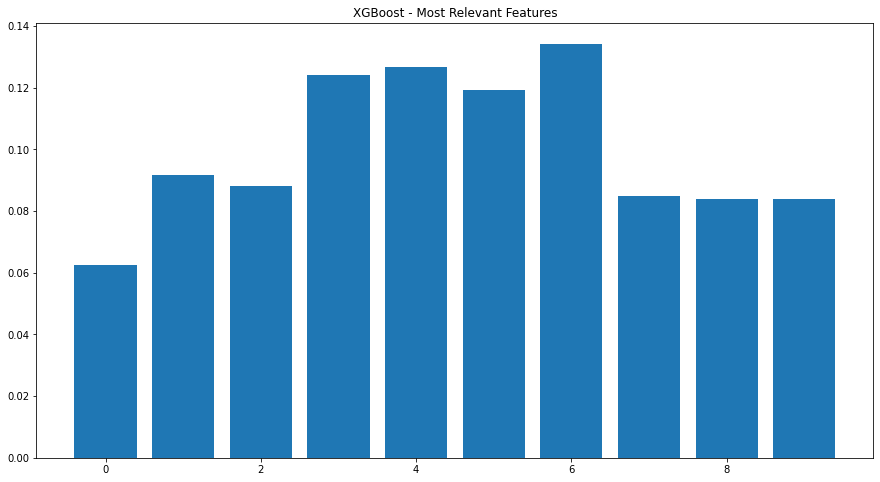

In [73]:
# plot
plt.bar(range(len(xgbr_model.best_estimator_.feature_importances_)), xgbr_model.best_estimator_.feature_importances_)
plt.title("XGBoost - Most Relevant Features")
plt.show()

In [74]:
xgb_best_feat = np.argsort(xgbr_model.best_estimator_.feature_importances_)[::-1]
print(xgb_best_feat)

[6 4 3 5 1 2 7 9 8 0]


In [75]:
# According to PCA algorithm the most relevant features are the following
print("XGBoost - Most relevant features:")
i = 1
for column in df_main.columns[xgb_best_feat]:        
    print(i, column)
    i += 1

XGBoost - Most relevant features:
1 asset_line
2 RUL
3 planned
4 asset_install_team
5 previous_unplanned
6 type_of_event
7 asset_material
8 asset_weather_cluster
9 asset_trains_per_hour
10 previous_repairs


Feature importance according to XGBoost algorithm. Results may vary giving the stochastic nature of the algorithm.

In [76]:
xgbr_res = pd.DataFrame({
    'Model': ['XGBoost Regressor'],
    'Test MAE': xgbr_test_score['mae'], 
    'Test MSE': xgbr_test_score['mse'], 
    'Test RMSE': xgbr_test_score['rmse'] 
})

r2 = r1.append(xgbr_res, ignore_index=True)

#### Support Vector Machine

In [77]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param = {'kernel': ["rbf", "sigmoid"]}
svr_model = GridSearchCV(svm.SVR(), param)
# svr_model = svm.SVR(kernel="rbf")
svr_model.fit(X_pca_train, y_train)

GridSearchCV(estimator=SVR(), param_grid={'kernel': ['rbf', 'sigmoid']})

In [78]:
svr_model.best_estimator_

SVR(kernel='sigmoid')

In [79]:
svr_pred_train = svr_model.predict(X_pca_train)
svr_train_score = evaluate(y_train, xgbr_pred_train)
print(svr_train_score)

{'mae': 94.17568795306866, 'mse': 21597.11823824709, 'rmse': 146.9595802873943}


In [80]:
svr_pred_test = svr_model.predict(X_pca_test)
svr_test_score = evaluate(y_test, svr_pred_test)
print(svr_test_score)

{'mae': 91.20428284864161, 'mse': 19590.620142338412, 'rmse': 139.9664964994781}


In [81]:
svr_res = pd.DataFrame({
    'Model': ['SVM'],
    'Test MAE': svr_test_score['mae'], 
    'Test MSE': svr_test_score['mse'], 
    'Test RMSE': svr_test_score['rmse'] 
})

r3 = r2.append(svr_res, ignore_index=True)

#### Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression

m = LogisticRegression(max_iter=500)
m.fit(X_pca_train, y_train)

LogisticRegression(max_iter=500)

In [83]:
lr_pred_test = m.predict(X_pca_test)
lr_test_score = evaluate(y_test, lr_pred_test)
print(lr_test_score)

{'mae': 103.05159705159706, 'mse': 17932.79606879607, 'rmse': 133.91339017736826}


In [84]:
lr_res = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Test MAE': lr_test_score['mae'], 
    'Test MSE': lr_test_score['mse'], 
    'Test RMSE': lr_test_score['rmse'] 
})

r4 = r3.append(lr_res, ignore_index=True)

<a id='bookmark_res'></a>
# Results & Conclusions <small> [<a href=#bookmark_index>Go to index</a>] </small>

In [85]:
r4

,Model,Test MAE,Test MSE,Test RMSE
0,Decision tree,92.843463,18124.441442,134.627046
1,Random Forest,128.370274,22346.316219,149.486843
2,XGBoost Regressor,98.071843,17705.838142,133.063286
3,SVM,91.204283,19590.620142,139.966496
4,Logistic Regression,103.051597,17932.796069,133.913390
